## Differential confounding of rare and common variants in spatially structured populations
Replication of tasks and observations by Iain Mathieson & Gil McVean (Nature Genetics 2012) using `msprime`. Based also on
_Mathieson, Iain. Genes in space: selection, association and variation in spatially structured populations. Diss. University of Oxford, 2013_.

Throughout this notebook, **RV, LF, CV** stand for rare, low frequency and common variants respectively. Moreover, similarly to the article, we use red for RV, blue for LF and green for CV. Although the original study uses two "versions" for each type of trait, here we focus in one. In particular, the nongenetic risk such that, for the Gaussian risk the phenotypic mean is shifted by at most 0.8 s.d., whereas for the small sharp risk it is shifted by at most 2 s.d.  

#### TODO:
* Continue with comments/explanation. Expand repetition and averaging of results.
* Calculate $F_{ST} = f(m)$ after dividing the grid to two halves. Check Fig 3.7 in _Chapter 3_.
* Differential patterns for varying types of non-genetic risk. Check _Appendix B_.

#### Long-term GOAL:
* Understand & define the problem with simulations, find the most appropriate solution, and apply on UKBB.  

_The problems of spatial structure increase as allele frequency decreases_

In [2]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from scipy.sparse.linalg import svds
from scipy.stats import norm, chi2
from scipy.stats import linregress as lm
from MySimUtils import create_MigMat, heatmap2d, multivariate_gaussian, Make_bins_2D
from MySimUtils import ManhDistance, Perform_PCA, AlleleSharing, GenomicControl
import pandas as pd
import os.path

### 0. Simulation of genotypes

In [3]:
# Global parameters : size of grid, sample-size per deme; Number of genes
K = 20; C=2;  N_G=10000 # Mathieson2012:
N_demes = K**2; deme_sizes = [C]*N_demes;  Ne = 5*sum(deme_sizes); mr = 10/Ne 
MR_info = {}
k_MigMat = create_MigMat(K, mr, stochastic=False)

k_pop_IDs = []; k_pop_configs = []; previous = 0
for k in range(N_demes):
    k_pop_configs.append( msprime.PopulationConfiguration(sample_size=deme_sizes[k], initial_size=Ne/N_demes) )
    k_pop_IDs.append( range(previous, previous+deme_sizes[k]) )
    previous += deme_sizes[k]
    
filein = "/data/hornbill/kalantzi/DCRV_Genotypes_Final_"+str(mr)
if os.path.exists(filein):
    print("Loading previously saved genotypes...")
    G = np.fromfile(filein, sep=',')
    G = G.reshape( int(G.shape[0]/K/K/C), K*K*C )
else:
    print( "Simulating a {0}x{0}x{3} grid with Ne={1}, mr={2} and {4} genes.".format(K,Ne,mr, deme_sizes[0], N_G))
    replicates = msprime.simulate( population_configurations=k_pop_configs, migration_matrix=k_MigMat,
                           recombination_rate=0, mutation_rate=1e-7, length=1200, num_replicates=N_G, random_seed=1)
    Nsnp=[0];
    G = np.empty( ( 10**7, sum(deme_sizes) ), dtype=np.int8 )
    for ts in replicates:
        Nsnp.append( Nsnp[-1] + ts.num_sites ) # the cumulative number of variants
        G[ Nsnp[-2]: Nsnp[-1], : ] = ts.genotype_matrix()

    G = G[:Nsnp[-1], :] # 
    G.tofile("DCRV_Genotypes_"+str(mr), sep=",", format="%s")
MR_info[mr] = [G]
print("{0} total variants, {1} per gene on average".format( G.shape[0], G.shape[0]/N_G))
# G.tofile("DCRV_Genotypes_"+str(MR))

Loading previously saved genotypes...
859584 total variants, 85.9584 per gene on average


#### Classify variants wrt DAF
As we follow the published study, we use the intervals $(0,0.04],(0.04,0.1], (0.1,0.5]$ for RV, LF and CV respectively; when the ancestral allele has DAF $<50\%$, we reverse it.

In [4]:
DAF = np.sum(G,axis=1)/G.shape[1]
bounds=[0.04,0.1,0.5]
MAF_Cluster = {'RV':[],'LF':[],'CV':[]}
for v in range(G.shape[0]):
    if DAF[v]>0.50: # convert to [0,0.5] 
        G[v,:] = 1 - G[v,:]
        DAF[v] = 1 - DAF[v] 
    if DAF[v]<= 0.04:
        MAF_Cluster['RV'].append(v) 
    elif DAF[v]<=0.1:
        MAF_Cluster['LF'].append(v)
    else:
        MAF_Cluster['CV'].append(v)
print( "Variants: Rare={0} | Low freq={1} | Common={2}".format( len(MAF_Cluster['RV']), len(MAF_Cluster['LF']),len(MAF_Cluster['CV'])) )

Variants: Rare=352637 | Low freq=140230 | Common=366717


###  Simulation of phenotypes

In [4]:
def sim_trait_with_NGR(case, N_samples=800, C=2):
    NGrisk = np.zeros((K,K));  # creation of the NG risk
   
    # parameters for the non-genetic risk
    if case=="sharp": # small and sharp | Q=2.2% | max=1 sd
        N=3; #effect=6.5
        X0, Y0 = np.random.randint(K-N, size=2) # select the center of the influence
#         Z = multivariate_gaussian(N, np.array([0., 0.]), effect*np.array([[ 1. , 0], [0,  1.]]) ) # (grid-size, mean, Cov)
        NGrisk[X0:X0+N, Y0:Y0+N] = 2 #2*Z/np.max(Z)
    elif case=="smooth": # Gaussian (smooth) | Q=1.4% | max=0.4 sd
        N=15; effect=1.75
        X0, Y0 = np.random.randint(K-N, size=2) # select the center of the influence
        Z = multivariate_gaussian(N, np.array([0., 0.]), effect*np.array([[1 , 0], [0,  1]]) ) # (grid-size, mean, Cov)
        NGrisk[X0:X0+N, Y0:Y0+N] = 0.8*Z/np.max(Z)
    else:
        print("Wrong case, choose sharp or smooth!")

    # simulation of the trait based on the non-genetic risk
    Trait = np.zeros(K*K*C); i=0
    for x in range(K):
        for y in range(K):
            Trait[i:i+C] = np.random.normal( NGrisk[x,y], scale=1, size=C) # C is samples per deme
            i+=2
    Q = np.var(NGrisk)/np.var(Trait)
    print("Proportion of the non-genetic risk in the phenotype = {0:.2f}%".format(100*Q))
    return Trait, NGrisk, Q

## 1. Differential inflation of rare and common variants

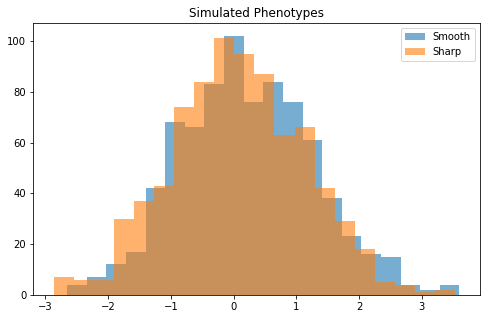

In [5]:
Trait_Info = {} # this will map "Trait" -> (trait_values, p_values, etc) and make plotting a piece of cake!
filein="DCRV_Traits.txt" # maybe !rm $filein ?

if os.path.exists(filein):
    df = pd.read_csv(filein, sep='\t')
    Trait_Info['Smooth'] = [ list(df['Smooth']) ]
    Trait_Info['Sharp' ] = [ list(df['Sharp' ]) ]
else:
    temp, NGrisk, _  = sim_trait_with_NGR("smooth")
    Trait_Info['Smooth'] = [temp]; heatmap2d(NGrisk)

    temp, NGrisk, _ = sim_trait_with_NGR("sharp")
    Trait_Info['Sharp']  = [temp]; heatmap2d(NGrisk)
    
    # save traits for reference and "repeating tasks"
    with open("DCRV_Traits.txt", 'w') as f:
        f.write("IID\tSmooth\tSharp\n")
        for i in range(K*K*C):
            f.write(str(i)+'\t'+str(Trait_Info['Smooth'][0][i])+'\t'+str(Trait_Info['Sharp'][0][i])+'\n')

f = plt.figure(figsize=(8,5)) 
for trait in Trait_Info:
    plt.hist( Trait_Info[trait], bins=20,  label=trait, alpha=0.6)
plt.legend(); plt.title("Simulated Phenotypes"); plt.show()

In [6]:
sample_list = range(G.shape[1]); locus_list = range(G.shape[0])
pvalues_smooth = []; pvalues_sharp = [];
snp_count = 0; samples = range(G.shape[1]) # pop_IDs[1] #
for locus, row in zip(locus_list, G):
    model = lm( row[ sample_list ], Trait_Info['Smooth'][0]) # Y=aX+b, X=row
    pvalues_smooth.append( model.pvalue )
    model = lm( row[ sample_list ], Trait_Info['Sharp' ][0]) # Y=aX+b, X=row
    pvalues_sharp.append(  model.pvalue )
    snp_count += 1
    if (snp_count % 100000 == 100):
        print("\rMore than",str(snp_count) + " markers are processed", end='')
print(" ...Finished!")
Trait_Info['Smooth'].append( pvalues_smooth )
Trait_Info['Sharp'].append( pvalues_sharp )
del pvalues_sharp, pvalues_smooth

More than 800100 markers are processed ...Finished!


#### Manhattan plots for the complete set of variants

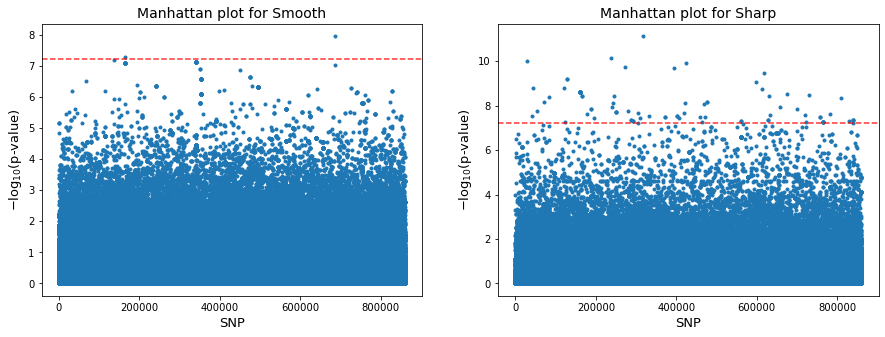

In [7]:
f, ax = plt.subplots(1,2, figsize=(15,5)) 

for i,trait in enumerate(Trait_Info):
    ax[i].plot(-np.log10( Trait_Info[trait][1] ), '.')
    ax[i].axhline(y=-np.log10(0.05/len(Trait_Info[trait][1])), color='r', linestyle='--', alpha=0.8)
    ax[i].set_ylabel(r"$-\log_{10}$(p-value)",fontsize=13)
    ax[i].set_xlabel("SNP",fontsize=13)
    ax[i].set_title("Manhattan plot for "+trait, fontsize=14)
plt.show()

### Plots similar to Fig. 1a,b

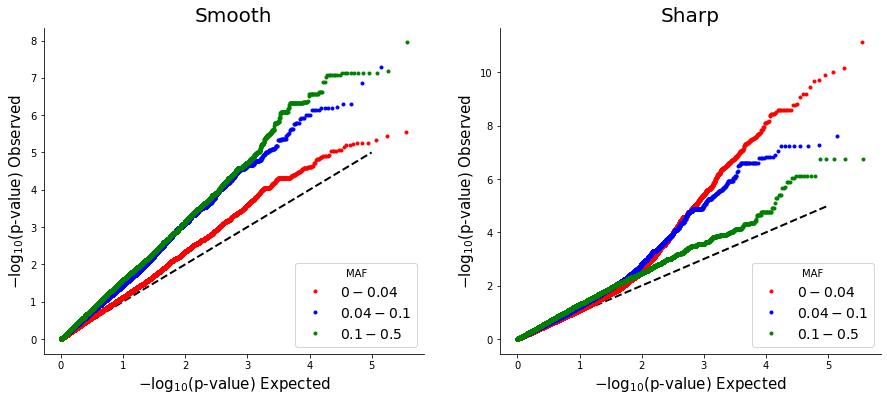

In [8]:
MAF_info={'RV':(r"$0-0.04$","red"), 'LF':(r"$0.04-0.1$",'blue'), 'CV':(r"$0.1-0.5$",'green')}
f, ax = plt.subplots(1,2, figsize=(15,6)) 

for i,trait in enumerate(Trait_Info):
    ax[i].plot( range(6), range(6), '--', color='black', linewidth=2)
    for var in ['RV','LF','CV']:
        indx = MAF_Cluster[var]
        pval_subset = [ Trait_Info[trait][1][x] for x in indx ]
        logobs = -np.log10(np.sort( pval_subset) )
        logexp = [-np.log10(x/(1+len(logobs))) for x in range(1,len(logobs)+1)]
        ax[i].plot( logexp, logobs,'.', label=MAF_info[var][0], color=MAF_info[var][1] )

    ax[i].set_xlabel(r"$-\log_{10}$(p-value) Expected", fontsize=15); ax[i].set_ylabel(r"$-\log_{10}$(p-value) Observed", fontsize=15)
    ax[i].legend(loc="lower right", title="MAF", fontsize=14)
    ax[i].set_title(trait, fontsize=20)
    ax[i].spines['right'].set_visible(False); ax[i].spines['top'].set_visible(False) # Hide the right and top spines
plt.savefig("DCRV_QQplots_MAF.png")
plt.show()

### Plots similar to Fig.1 c-d
Although the message was interesting for these plot, I found the description not clear enough for the purpose of replicating. Thus I failed to deliver something useful here.

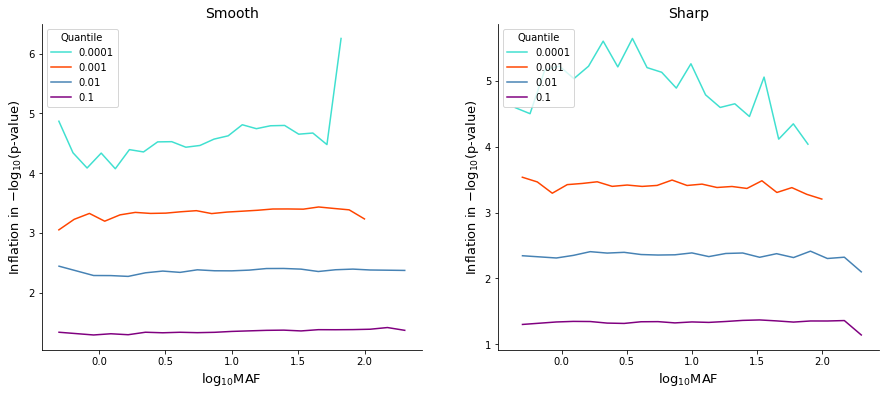

In [9]:
Quantiles={0.0001:([],'turquoise'), 0.001:([],"orangered"), 0.01:([],'steelblue'), 0.1:([],'purple')}
# Quantiles={0.1:([],'purple'), 0.01:([],'steelblue'), 0.001:([],"orangered"), 0.0001:([],'turquoise') }
M = G.shape[0]
f, ax = plt.subplots(1,2, figsize=(15,6)) 
for i,trait in enumerate(Trait_Info):
    previous = 0; 
    for level in Quantiles:

        indx = [ v for v in range(M) if Trait_Info[trait][1][v]<=level and Trait_Info[trait][1][v]>previous ]
        X = [ np.log10(DAF[x]) for x in indx ] # get the subset
        pvals = [ -np.log10(Trait_Info[trait][1][x]) for x in indx ]
       
        if len(indx)>1:
            A, B = Make_bins_2D(X, pvals, Ncuts=20 )
            ax[i].plot(A, B, label=str(level), color=Quantiles[level][1])
        previous=level

    ax[i].set_xlabel(r"$\log_{10}$MAF", fontsize=13); 
    ax[i].set_ylabel(r"Inflation in $-\log_{10}$(p-value)", fontsize=13)
    ax[i].legend(loc="upper left", title="Quantile")
    ax[i].set_title(trait, fontsize=14)
    ax[i].spines['right'].set_visible(False); ax[i].spines['top'].set_visible(False) # Hide the right and top spines
plt.savefig("DCRV_Fig1cd.png")
plt.show()

## 2. Spatial distribution of rare and common variants
We are now investigating the spatial distribution of each type of variants. We select a random variant for each type, locate the demes containing these carriers, and plot the corresponding squares with darker colors.

_Note that the rare variant has a tightly clustered spatial distribution while the common variant has a much more irregular distribution_

MAC for current RV variant = 15.0 / 800
MAC for current LF variant = 77.0 / 800
MAC for current CV variant = 319.0 / 800


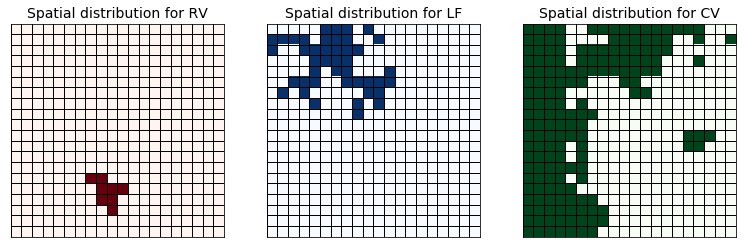

In [10]:
f, ax = plt.subplots(1,3, figsize=(13,5)) 
cmaps={'RV':"Reds", 'LF':'Blues', 'CV':'Greens'}

for i,case in enumerate( ['RV','LF','CV'] ):
    v = MAF_Cluster[case][ np.random.randint(len(MAF_Cluster[case])) ]
    print( "MAC for current "+case+" variant =",sum(G[v,:]),"/", G.shape[1] )
    # find demes - each two individuals belong to the same deme
    demes = []
    for D in range(K*K):
        if G[v,2*D]>0 or G[v,2*D+1]>0:
            demes.append(D)
#     print("Demes with carriers = ",demes)
    # create matrix-type to draw
    Loc = np.zeros(K*K); Loc[demes] = 1; Loc = Loc.reshape(20,20) 

    for x in np.linspace(-0.5,K+0.5,K+2): # these are for a suitable grid:
        ax[i].axhline(x-0.07, lw=1, color='k', zorder=1)
        ax[i].axvline(x, lw=1, color='k', zorder=1)
    ax[i].imshow(Loc, cmap=cmaps[case])
    ax[i].set_xticks([]); ax[i].set_yticks([]) # no need for deme-labelling
    ax[i].set_title("Spatial distribution for "+case,fontsize=14)
plt.savefig("DCRV_SpatialDistr.png")
plt.show()

### Distributions of the correlation coefficient between genotypes and nongenetic risks | Fig. 2d,e
For this task, we are going to plot the distributions, as KDE, of the correlation coefficients between genotypes (0 or 1) and associated environmental risk.  

_Intuitively, rare variants are more likely to be highly spatially clustered (Figure 3.5a) and therefore when the non-genetic risk is highly clustered, some rare variants will have spatial distribution almost exactly equal to the spatial distribution of the risk, and they will be strongly associated with the trait. We demonstrate this in Figure 3.9 which shows the distribution of correlation coeﬃcients between genotype and non-genetic risk in the two cases described here. Rare variants cannot be highly correlated with the smoothly varying risk, but they can be highly correlated with risk that occurs in small, sharp patches._

_(...) there is a long tail of rare variants which are highly correlated with the distribution of the risk._

Smooth RV | Smooth LF | Smooth CV | Sharp RV | Sharp LF | Sharp CV | 

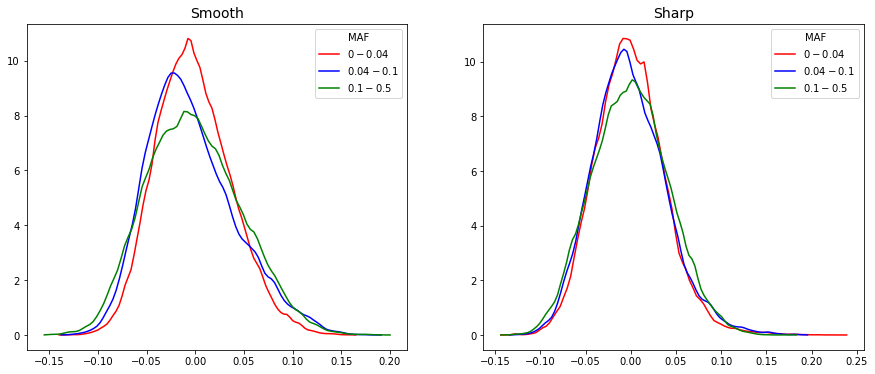

In [11]:
f, ax = plt.subplots(1,2, figsize=(15,6)) 
for i,trait in enumerate(Trait_Info):
    for case in ['RV','LF','CV'] :
        print(trait,case,"| ",end='')
        CorCoef = []
        for snp in MAF_Cluster[case]:
            CorCoef.append( np.corrcoef(G[snp,:], Trait_Info[trait][0] )[0,1] )
        KDE = stats.gaussian_kde( CorCoef )
        X = np.linspace(min(CorCoef), max(CorCoef), 100)
        Y = KDE.evaluate(X) # get the prob of every intermediate value
        ax[i].plot(X,Y, label=MAF_info[case][0], color=MAF_info[case][1])
    ax[i].set_title(trait, fontsize=14)
    ax[i].legend(loc="upper right", title="MAF")
plt.show()

## 3. Correcting for population structure
We will repeat the pseudo-GWAS on the smooth and sharp traits, this type with more special techniques. The `Trait_Info` contains already the p-values for the **Uncorrected** test, so we need to evaluate Genomic Control (**GC**) and perform tests using 10 principal components as covariates, either after using all markers (**PCA**) the rare variants only (**Rare PCA**), and linear mixed model (**LMM**).

**Notice**: At the end, the `Trait_Info` should map each trait to a list of [*trait_values, pval_uncorrected, pval_GC, pval_PCA, pval_rarePCA, pval_LMM*]

#### 1. Genomic Control
The genomic inflation constant  $\lambda$ is defined as  $ \lambda = \frac{<X_{l}>}{\chi_{1,0.50}^2}$, where $X_l$ is the inverse of the cumulative distribution of a $\chi_{1}^2$, calculated at the corresponding p-value. That is the factor by which we need to adjust the test statistics and then re-estimate the pvalues. *If that's more than 1.05 there's an oversestimation of the p-values*. 

In [12]:
for trait in Trait_Info:
    temp, lamda = GenomicControl(Trait_Info[trait][1])
    Trait_Info[trait].append(temp)

Genomic inflation constant = 1.610880587837358
Genomic inflation constant = 1.2671128900951172


#### 2. PCA: Inclusion of principal components of ancestry as covariates
We first need to perform PCA on the genotype matrix (which is done earlier) and then adjust each trait for the first few principal components. Similarly to the article, we select 10. After the phenotypic adjustment, we test again using a simple linear model.

In [13]:
from sklearn.linear_model import LinearRegression as MLR
D,V = Perform_PCA(G)

for i,trait in enumerate(Trait_Info):
    trait_before = Trait_Info[trait][0]
    model = MLR().fit( V[:,:10], trait_before ) # phenotypic adjustment
    trait_adj = trait_before - model.predict( V[:,:10] ) # the residuals

    pvalues = []; snp_count = 0;
    for locus, row in zip(locus_list, G):
        model = lm(row, trait_adj)
        pvalues.append( model.pvalue )
        snp_count += 1
        if (snp_count % 100000 == 100):
            print("\rMore than",str(snp_count) + " markers are processed...", end='')
    Trait_Info[trait].append(pvalues) # "save" results
    print(" Finished for "+trait)

More than 800100 markers are processed... Finished for Smooth
More than 800100 markers are processed... Finished for Sharp


#### 3. Rare PCA: As before but using only rare variants for the PCA

In [14]:
G_rare = G[ MAF_Cluster['RV'], :]
[D,V] = Perform_PCA(G_rare); # this returns the singular values in decreased order
V = V.astype(float) # get rid of imaginary parts

for i,trait in enumerate(Trait_Info):
    trait_before = Trait_Info[trait][0]
    model = MLR().fit( V[:,:10], trait_before ) # phenotypic adjustment
    trait_adj = trait_before - model.predict( V[:,:10] ) # the residuals

    pvalues = []; snp_count = 0;
    for locus, row in zip(locus_list, G):
        model = lm(row, trait_adj)
        pvalues.append( model.pvalue )
        snp_count += 1
        if (snp_count % 100000 == 100):
            print("\rMore than",str(snp_count) + " markers are processed", end='')
    Trait_Info[trait].append(pvalues) # "save" results
    print(" ...Finished for "+trait)

More than 800100 markers are processed ...Finished for Smooth
More than 800100 markers are processed ...Finished for Sharp


#### 4. Linear Mixed Model

We utilise a model according to which $Y = \mu + \beta X +\epsilon_G + \epsilon_R$, where $\epsilon_G \sim \mathcal{N}_N(0,\sigma_G^2R)$ and $\epsilon_R \sim \mathcal{N}_N(0,\sigma_R^2I)$ for some fixed $\sigma_G^2$ and $\sigma_R^2$ and $R$ being the fixed kinship matrix. This analysis would be similar as that implemented in other software tools such as EMMAX, FaST-LMM and GEMMA. The genotype matrix has already been transformed to bed/bim/fam format (using plink).

In [25]:
%cd LMM/
!./gcta64 --bfile {genofile} --mlma  --pheno Traits.phen --mpheno 1 --threads 5 --out DCRV_MLM_Smooth
!./gcta64 --bfile {genofile} --mlma  --pheno Traits.phen --mpheno 2 --threads 5 --out DCRV_MLM_Sharp

for trait in Trait_Info:
    sumstats = pd.read_csv("DCRV_MLM_"+trait+".mlma", sep='\t')
    Trait_Info[trait].append(sumstats['p'])
%cd ../

### Plots similar to Fig. 3a,b

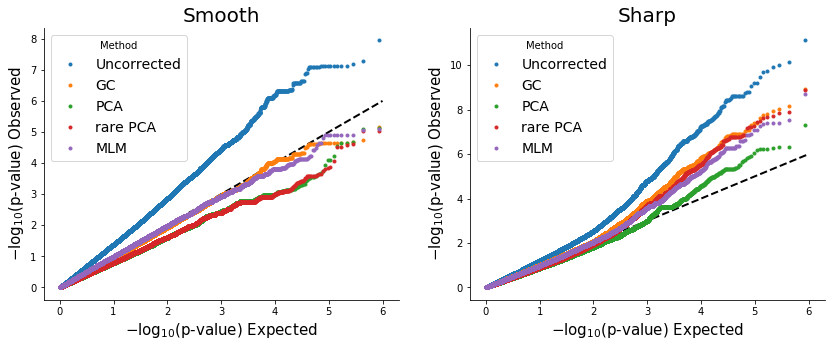

In [28]:
# del G, G_rare # save RAM 
f, ax = plt.subplots(1,2, figsize=(14,5)) 
for i,trait in enumerate(Trait_Info):
    ax[i].plot( range(7), range(7), '--', color='black', linewidth=2)
    for j,case in enumerate(["Uncorrected", "GC", "PCA", "rare PCA","MLM"]):
        logobs = -np.log10( np.sort(Trait_Info[trait][j+1]) )
        logexp = [-np.log10(x/(1+len(logobs))) for x in range(1,len(logobs)+1)]
        ax[i].plot(logexp, logobs, '.', label=case)

    ax[i].set_xlabel(r"$-\log_{10}$(p-value) Expected", fontsize=15)
    ax[i].set_ylabel(r"$-\log_{10}$(p-value) Observed", fontsize=15)
    ax[i].set_title(trait, fontsize=20)
    ax[i].legend(loc="upper left", title="Method", fontsize=14)
    ax[i].spines['right'].set_visible(False); ax[i].spines['top'].set_visible(False) # Hide the right and top spines
plt.savefig("DCRV_QQplots_Correction.png")
plt.show()

## 4. Load (Burden) tests for RV
" _To assess the effects of stratification of such aggregating tests, we considered one of the simplest 'load-based' tests, which tests association with the number of rare variants carried in a region, typically a gene. For smoothly varying Gaussian risk, test statistic inflation was largely independent of the number of variants considered (Fig. 3c). For sharply defined risk, test statistic inflation was reduced as more variants were considered but still increased sharply for low P values (Fig. 3d).  
Note that in the case of small, sharp risk (b), the burden test goes some way towards removing the eﬀect, but does not do so entirely. Increasing the number of variants to more than 10 does not change the results._ "

**Warning:** "In c and d, results were averaged over 10 simulations, each one testing 10,000 genealogies with either 1, 3 or 10 variants in each." Taking as many as 10K genes will require more than 25 hours of running time. To avoid that, I've prepared `DCRV_Burden_Rep.py` which can be used for parallelisation. Then we can run the next block of code to collect results.

For this task I proceed as follows. I simulate $N_G$ indepedent genes (ie,genealogies) that are sufficiently large to contain at least $10$ rare (ie DAF<$4\%$) variants. Then I keep the first 10 rare variants, discard the rest, and evaluate 3 models, each counting 1,3 or 10 variants in each locus, and this is done for both traits. I repeat this process $N_{rep}$ times, averaging the logarithms of the sorted p-values, and draw the corresponding QQ plot, one for each trait as usually.

In [16]:
N_G=10000; N_Rep=10
LogPval_final = np.zeros( (N_G,6) )
for rep in range(N_Rep):
    filein="DCRV_Burden_"+str(N_G)+"_"+str(rep)+".tab"
    if os.path.exists(filein):
        instance = pd.read_csv(filein, sep='\t', header=None).to_numpy()
        LogPval_final += instance /N_Rep # the estiamtes are already sorted
    else:
        print("Results are missing or task",rep,"is not complete yet")
        #  for t in {0..9}; do python DCRV_Burden_Rep.py 10000 $t & done

### Plots similar to Fig. 3c,d
Normally, for the sharply defined risk, test statistic inflation should be reduced as more variants are considered, besides, possibly, the very low p-values. I failed to reproduce this observation though.

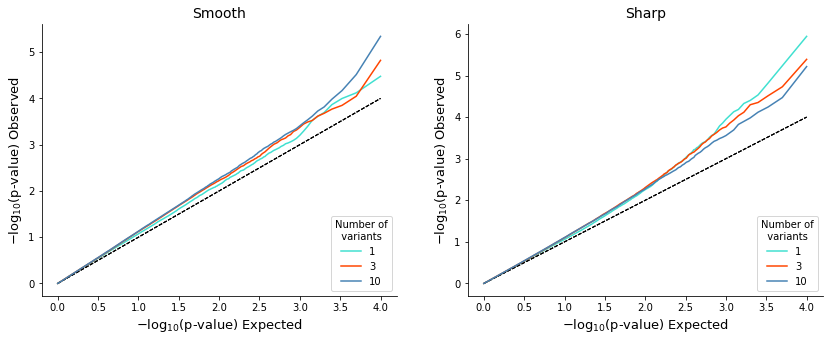

In [17]:
VARS={1:'turquoise', 3:"orangered", 10:'steelblue'}
f, ax = plt.subplots(1,2, figsize=(14,5)) 
N_G = LogPval_final.shape[0]; limit= int(np.log10(N_G))+1
for i,trait in enumerate(Trait_Info):
    for t,var in enumerate(VARS):
        ax[i].plot( range(limit), range(limit), '--', color='black', linewidth=1)
        logobs = np.sort( LogPval_final[:, t+3*i] )[::-1] # column index is [0,1,2] or [3,4,5]
        logexp = [-np.log10(x/(1+len(logobs))) for x in range(1,len(logobs)+1)]
        ax[i].plot(logexp, logobs, '-', label=str(var), color=VARS[var])

        ax[i].set_xlabel(r"$-\log_{10}$(p-value) Expected", fontsize=13)
        ax[i].set_ylabel(r"$-\log_{10}$(p-value) Observed", fontsize=13)
        ax[i].set_title(trait, fontsize=14)
        ax[i].legend(loc="lower right", title="Number of\n  variants")
        ax[i].spines['right'].set_visible(False); ax[i].spines['top'].set_visible(False) # Hide the right and top spines
plt.savefig("DCRV_Burden_"+str(N_Rep)+"x"+str(N_G)+".png")

## 5. Allele sharing as a function of distance
For this task we are measurring _how much more likely two individuals at a given spatial distance are to share a derived allele compare to what would be expected in a homogeneous population._ We use a form of _Moran's I statistic_ defined for sets of variants and calculate this for the three sets of variants. 

As this calculation is demanding, we strict ourselves to 300 random markers from each set and just show previously calculated results. These are obtained after the current parametrisation ($N_G=10000$ and `Mig_rate`$=0.0025$) along with a similar grid setup but with $N_G=1000$ and `Mig_rate`$=0.25$.

In accordance with the paper, the lower migration rate leads to a highly structured population, whereas the higher one leads to a relatively unstructured population. In both cases, however, we notice excess sharing rare variants. 
<img src="DCRV_EAS_300vars.png" width="1000">